# Sentiment Analysis: Statistical Insights

This notebook demonstrates statistical analyses to gain insights from sentiment predictions generated by a BERT-based multi-task sentiment analysis model. The analyses include:
1. Correlation analysis between aspects
2. Word clouds for sentiment-aspect associations
3. Sentiment distribution analysis
4. Aspect importance analysis
5. Sentiment trend analysis over time
6. Sentiment co-occurrence analysis

We assume a dataset of Chinese restaurant reviews with sentiment labels for 18 aspects (e.g., Food#Taste, Service#Hospitality). For demonstration, we simulate a small dataset.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
from tqdm import tqdm
from itertools import combinations
from datetime import datetime
from model import MultiTaskSentimentModel
from schemas import ReviewInput

%matplotlib inline

## 1. Load Data

We the training data to simulate a dataset that is predicted using our models. In practice, replace this with the actual dataset of a restaurant.

In [2]:
aspects = MultiTaskSentimentModel.ASPECT_COLUMNS
sentiment_map = {0: "not_mentioned", 1: "negative", 2: "neutral", 3: "positive"}
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}


# Read the data
data = pd.read_csv("../data/train.csv")

df = pd.DataFrame(data)

## 2. Correlation Analysis

Compute and visualize correlations between aspect sentiments to identify relationships.

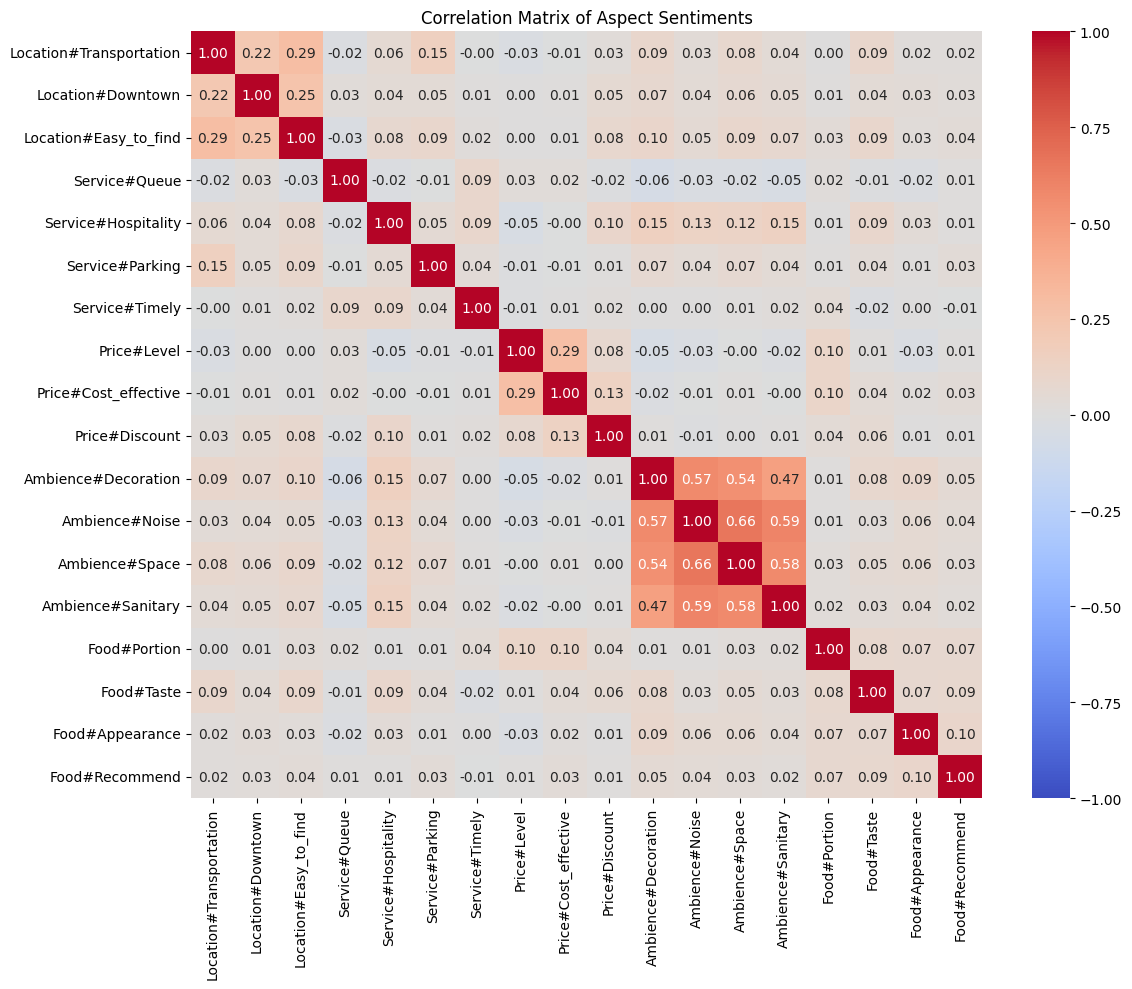

In [3]:
numerical_df = df[aspects].replace(reverse_sentiment_map)

# Compute Spearman correlation matrix
corr_matrix = numerical_df.corr(method="spearman")

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, fmt=".2f")
plt.title("Correlation Matrix of Aspect Sentiments")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

**Interpretation**: Strong positive correlations (red) indicate aspects that tend to have similar sentiments. For example, a high correlation between Price#Level and Price#Cost_effective

## 3. Word Clouds for Sentiment-Aspect Associations

Generate word clouds for words associated with specific sentiments in each aspect.

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.333 seconds.
Prefix dict has been built successfully.


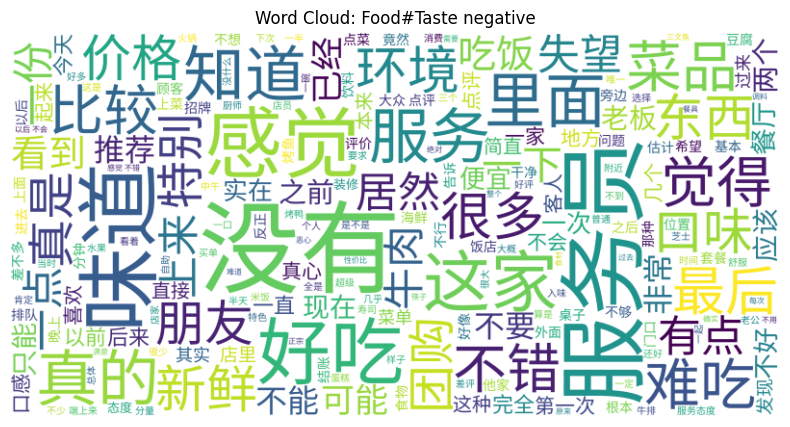

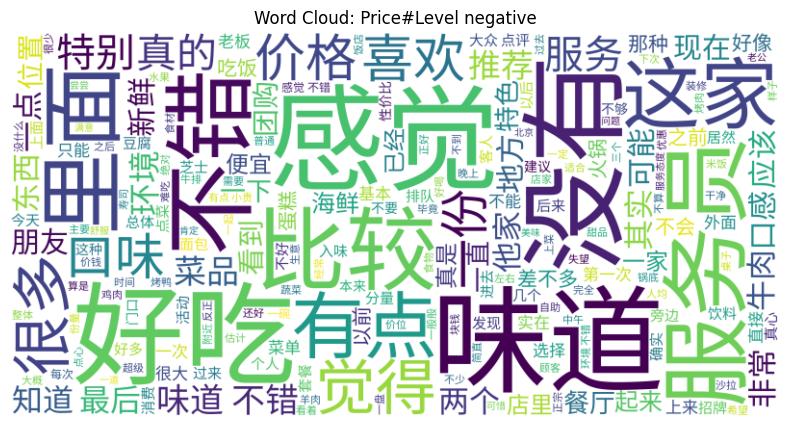

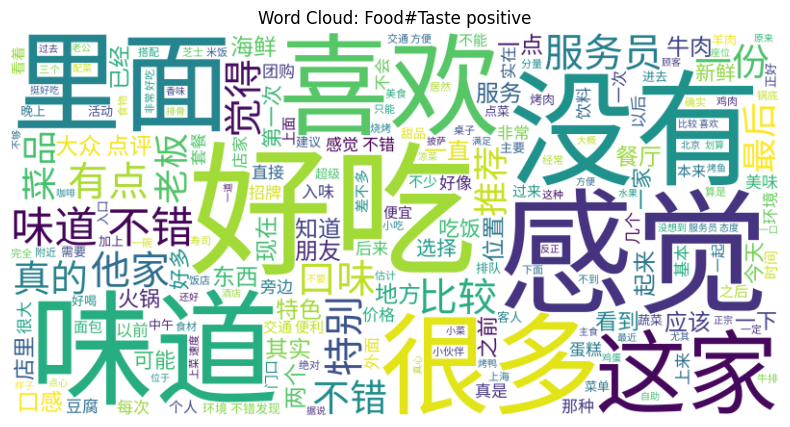

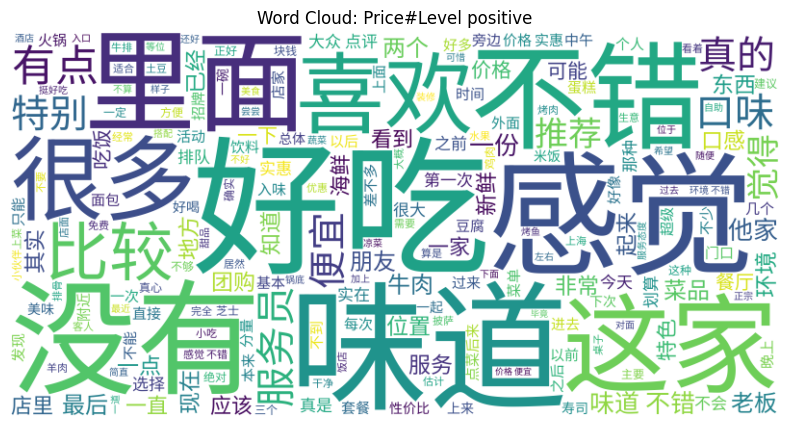

In [4]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import jieba

FONT_PATH = "../NotoSansSC-Regular.ttf"
aspects = ["Food#Taste", "Price#Level"]
sentiments = [-1, 1]

# Load stop words from file
try:
    with open("stop_words.txt", "r", encoding="utf-8") as f:
        stop_words = set(f.read().strip().split("\n"))
except FileNotFoundError:
    print("Error: stop_words.txt not found. Using a minimal stop words set.")
    stop_words = {
        "的",
        "是",
        "在",
        "了",
        "和",
        "很",
        "就",
        "也",
        "都",
        "这",
        "那",
        "个",
        "不",
        "没有",
    }


def generate_wordcloud(texts, sentiment, aspect):
    if not texts.empty:
        # Tokenize with jieba and remove stop words
        words = []
        for text in texts:
            tokens = jieba.cut(text)
            filtered_tokens = [
                token for token in tokens if token not in stop_words and len(token) > 1
            ]
            words.extend(filtered_tokens)
        text = " ".join(words)

        # Generate word cloud
        try:
            wordcloud = WordCloud(
                font_path=FONT_PATH, width=800, height=400, background_color="white"
            ).generate(text)

            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation="bilinear")
            plt.axis("off")
            plt.title(
                f"Word Cloud: {aspect} {'negative' if sentiment == -1 else 'positive'}"
            )
            plt.savefig(
                f"wordcloud_{aspect}_{'negative' if sentiment == -1 else 'positive'}.png"
            )
            plt.show()
        except OSError as e:
            print(f"Error loading font at {FONT_PATH}: {e}")
            print("Please verify the font path or install Noto Sans SC.")
    else:
        print(
            f"No reviews found for {aspect} with {sentiment} sentiment. Trying alternative."
        )


for sentiment in sentiments:
    for aspect in aspects:
        texts = df[df[aspect] == sentiment]["review"]
        generate_wordcloud(texts, sentiment, aspect)

**Interpretation**: The word cloud highlights frequent terms in positive Food#Taste reviews (e.g., '美味', '好吃'). Repeat for other aspects/sentiments as needed.

## 4. Sentiment Co-Occurrence Analysis

Analyze how often sentiments co-occur across aspects.

In [5]:
def generate_cooccurrence_matrix(df, aspects, sentiments):
    # Create a list of all aspect-sentiment pairs
    aspect_sentiment_pairs = [
        (aspect, sentiment) for aspect in aspects for sentiment in sentiments
    ]

    # Initialize the co-occurrence matrix with zeros
    cooccurrence_matrix = np.zeros(
        (len(aspect_sentiment_pairs), len(aspect_sentiment_pairs)), dtype=int
    )
    cooccurrence_df = pd.DataFrame(
        cooccurrence_matrix,
        index=[f"{aspect}_{sentiment}" for aspect, sentiment in aspect_sentiment_pairs],
        columns=[
            f"{aspect}_{sentiment}" for aspect, sentiment in aspect_sentiment_pairs
        ],
    )

    # Iterate through each review with a progress bar
    for index, row in tqdm(df.iterrows(), total=len(df), desc="Processing Reviews"):
        # Find which aspect-sentiment pairs are present in the current review
        present_pairs = []
        for aspect, sentiment in aspect_sentiment_pairs:
            if row[aspect] == sentiment:
                present_pairs.append((aspect, sentiment))

        # Update the co-occurrence matrix
        for i, (aspect1, sentiment1) in enumerate(present_pairs):
            for j, (aspect2, sentiment2) in enumerate(present_pairs):
                cooccurrence_df.loc[
                    f"{aspect1}_{sentiment1}", f"{aspect2}_{sentiment2}"
                ] += 1

    return cooccurrence_df


aspects = MultiTaskSentimentModel.ASPECT_COLUMNS
sentiments = [-2, -1, 0, 1]


# Generate the co-occurrence matrix
cooccurrence_matrix = generate_cooccurrence_matrix(df, aspects, sentiments)

# Print the co-occurrence matrix
print(cooccurrence_matrix)

Processing Reviews: 100%|██████████| 36850/36850 [04:15<00:00, 144.42it/s]

                            Location#Transportation_-2  \
Location#Transportation_-2                       29501   
Location#Transportation_-1                           0   
Location#Transportation_0                            0   
Location#Transportation_1                            0   
Location#Downtown_-2                             25683   
...                                                ...   
Food#Appearance_1                                 5356   
Food#Recommend_-2                                24144   
Food#Recommend_-1                                  651   
Food#Recommend_0                                   528   
Food#Recommend_1                                  4178   

                            Location#Transportation_-1  \
Location#Transportation_-2                           0   
Location#Transportation_-1                         441   
Location#Transportation_0                            0   
Location#Transportation_1                            0   
Location#Down

**Interpretation**: Frequent co-occurrences (e.g., positive Food#Taste with positive Service#Hospitality) indicate common customer experience patterns.

In [6]:
cooccurrence_matrix.to_csv("cooccurrence_matrix.csv")

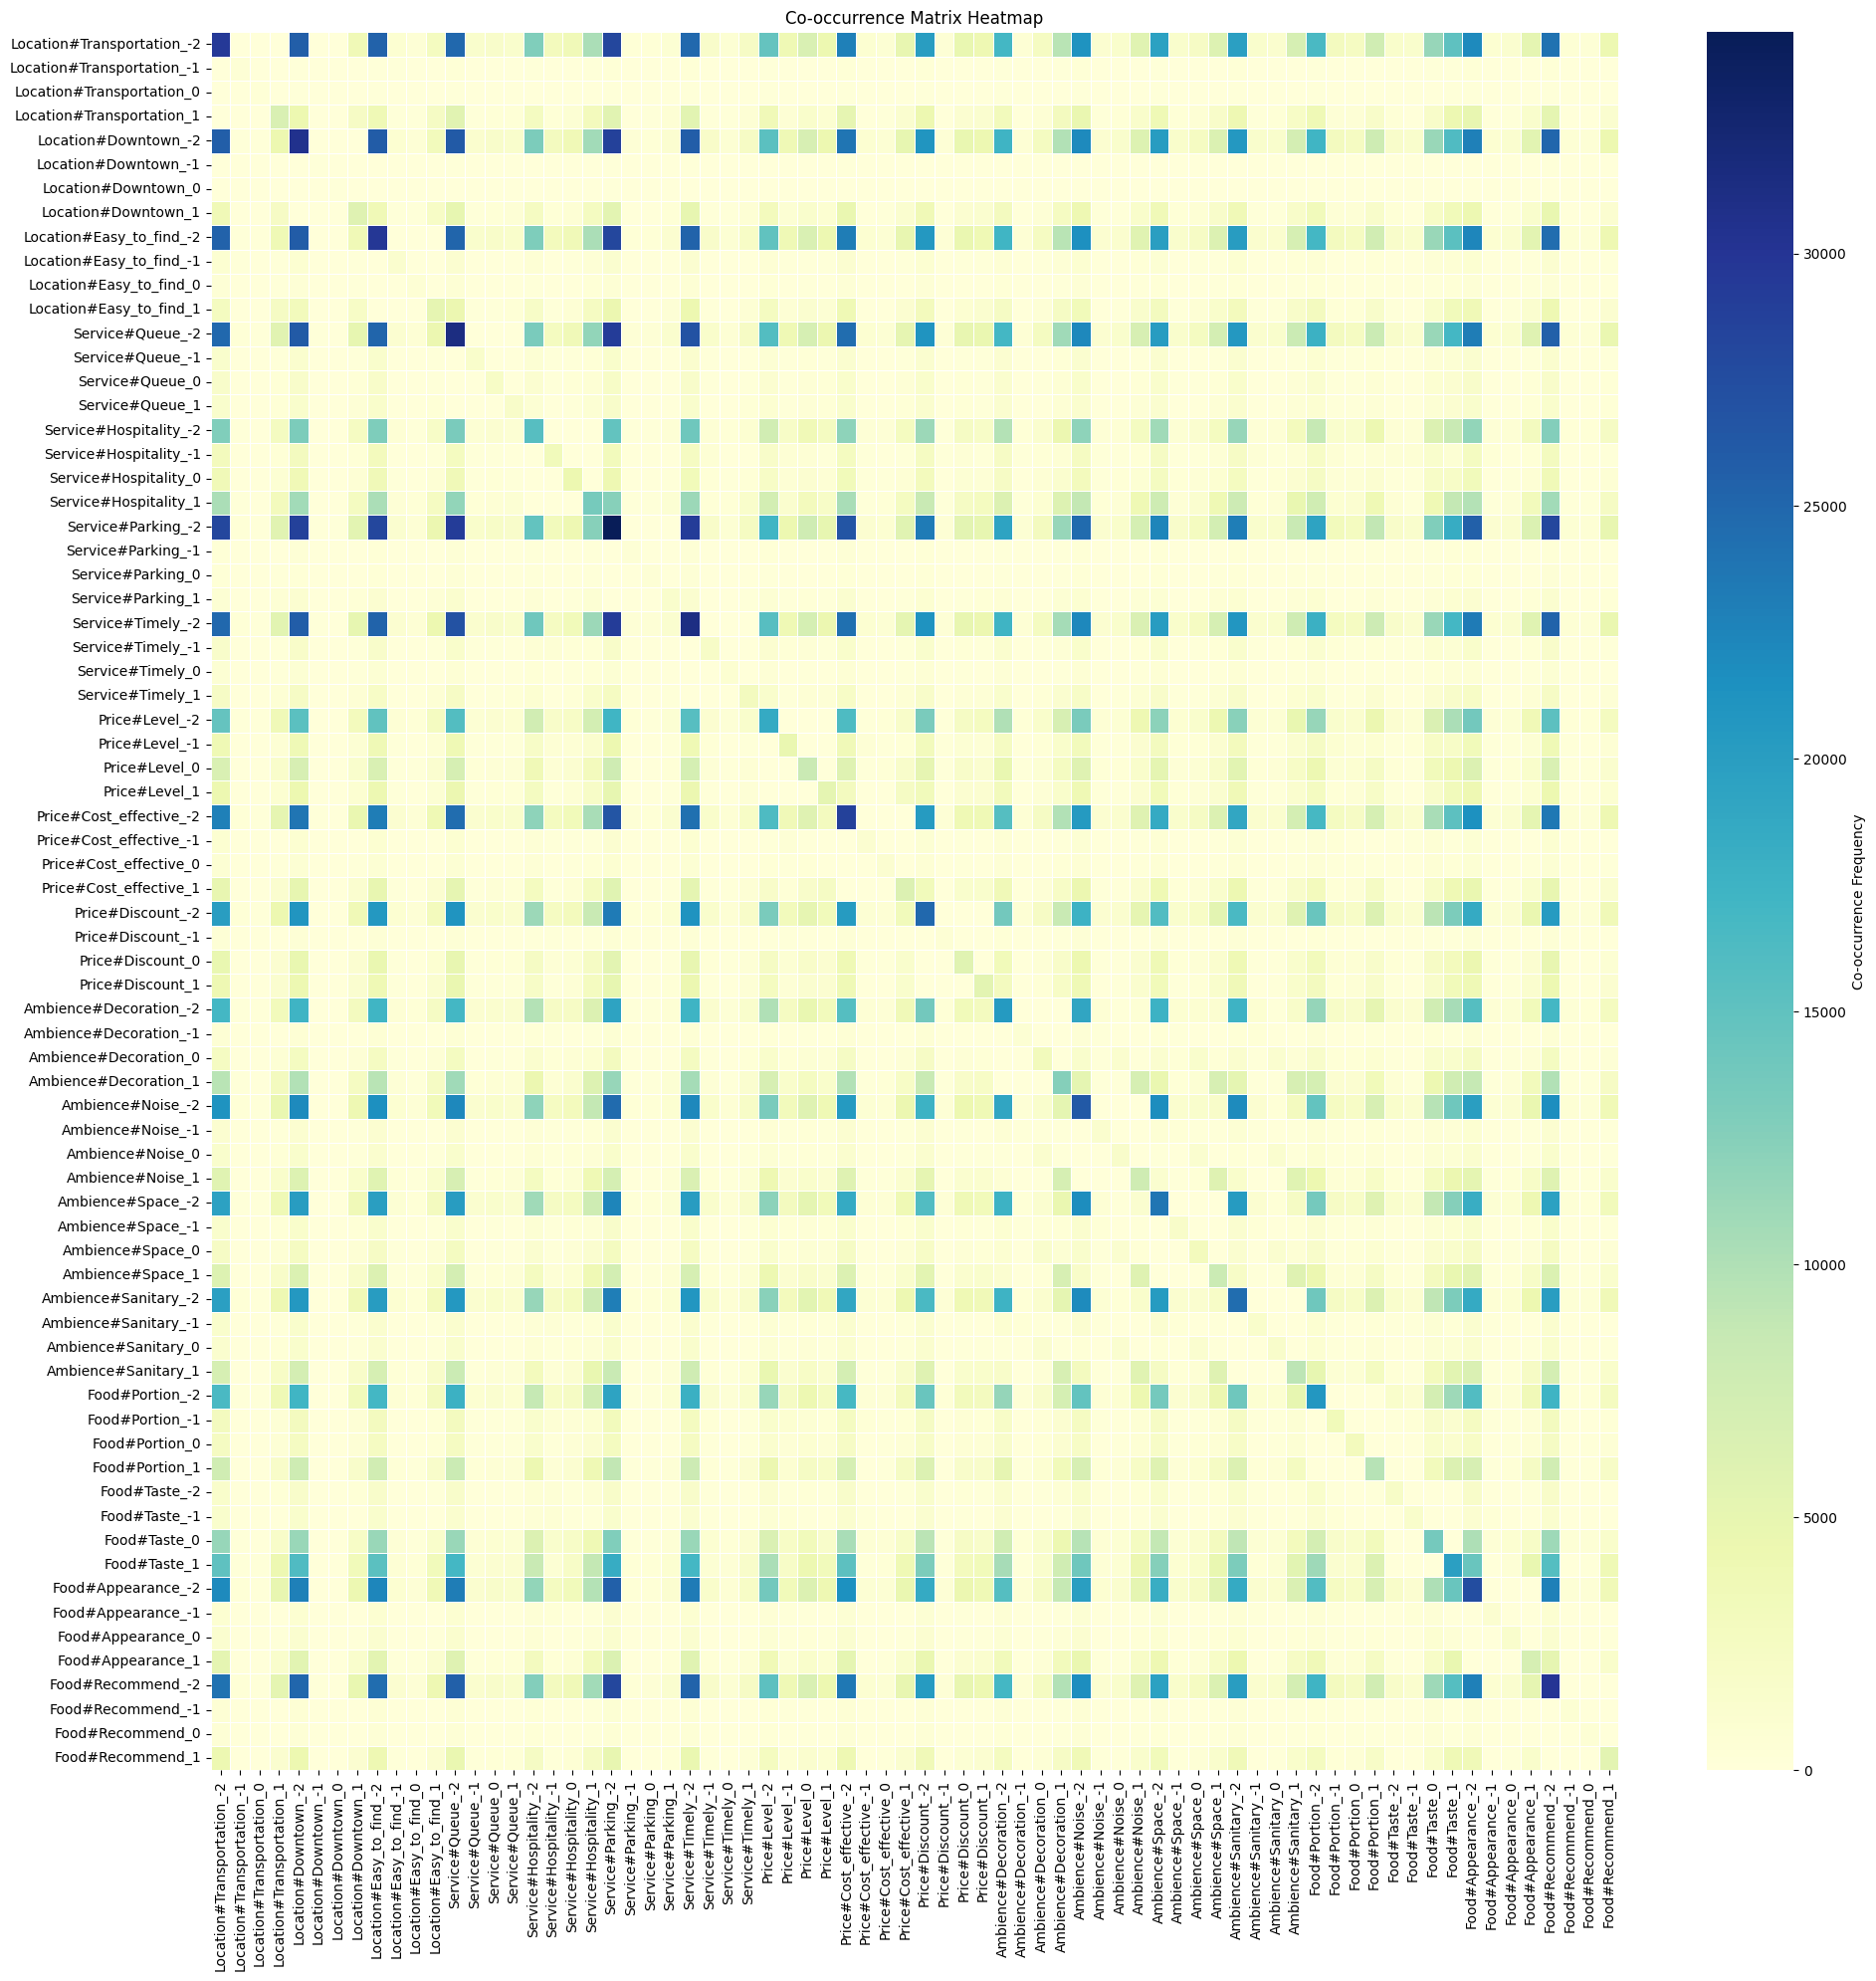

In [7]:
try:
    cooccurrence_matrix = pd.read_csv(
        "cooccurrence_matrix.csv", index_col=0
    )  # Set the first column as the index
except FileNotFoundError:
    print("Error: cooccurrence_matrix.csv not found.  Make sure the file exists.")
    exit()

# Create the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(
    cooccurrence_matrix,
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Co-occurrence Frequency"},
)
plt.title("Co-occurrence Matrix Heatmap")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig("cooccurrence_heatmap_from_csv.png")
plt.show()

#### 5. Contigency Table and Chi-squared Test

Results exported to 'chi_square_results.csv'


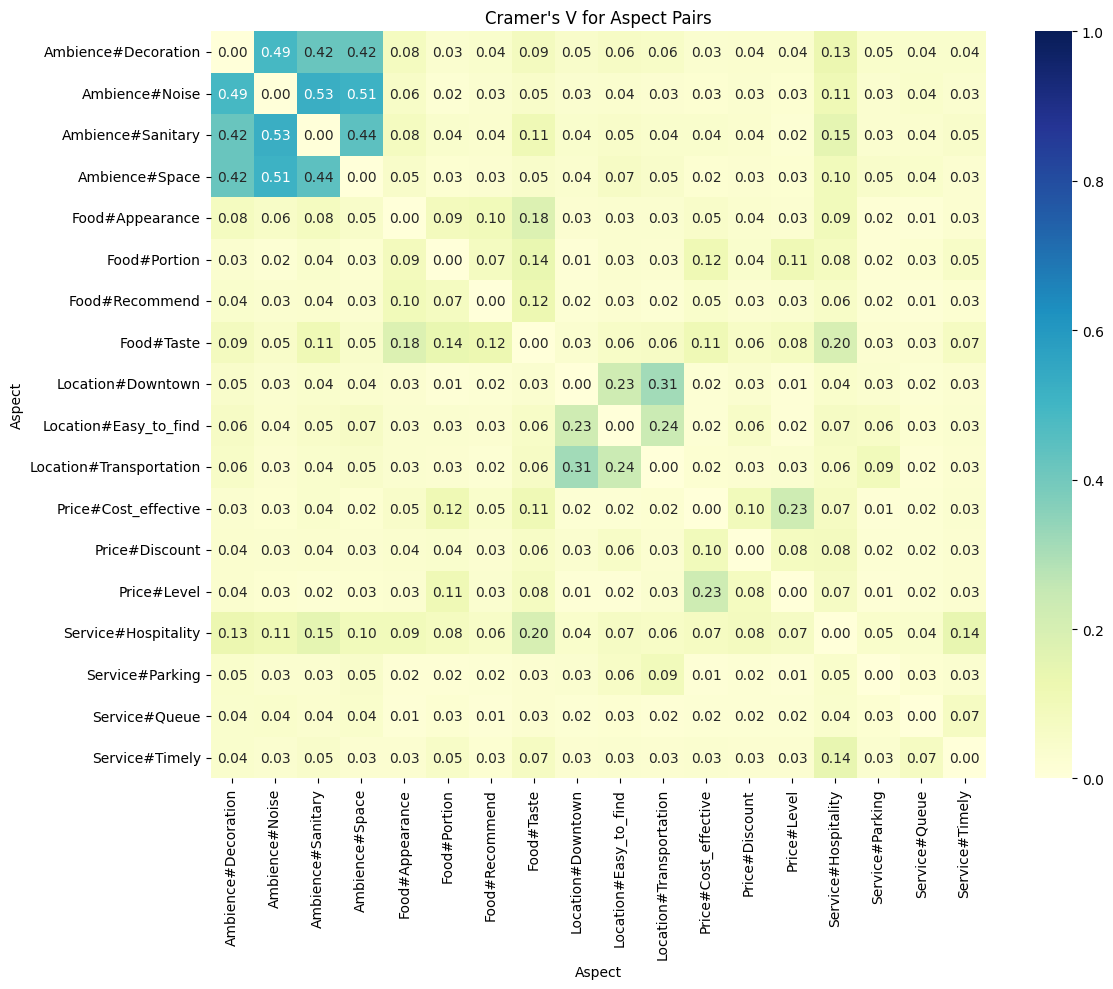

In [8]:
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt


# Define Cramer's V function
def crammers_v(chi2, n, r, c):
    return np.sqrt(chi2 / n / min(c - 1, r - 1))


# Assuming df and aspects are defined
# Example: df = pd.DataFrame(...), aspects = ['Food#Taste', 'Service#Queue', ...]

# Generate all pairs of aspects
aspect_pairs = combinations(aspects, 2)

# Store results
results = []

# Perform chi-square test for each pair
for aspect1, aspect2 in aspect_pairs:
    contingency_table = pd.crosstab(df[aspect1], df[aspect2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    n = contingency_table.sum().sum()  # Total observations
    r, c = contingency_table.shape  # Rows, columns
    cramer_v = crammers_v(chi2, n, r, c)

    # Append results to list
    results.append(
        {
            "Aspect_Pair": f"{aspect1} vs {aspect2}",
            "Aspect1": aspect1,
            "Aspect2": aspect2,
            "Chi2_Statistic": chi2,
            "P_Value": p,
            "Degrees_of_Freedom": dof,
            "Cramers_V": cramer_v,
        }
    )

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Export to CSV (optional, as per your previous request)
results_df.to_csv("chi_square_results.csv", index=False)
print("Results exported to 'chi_square_results.csv'")

# Create pivot table for Cramer's V
pivot = results_df.pivot(index="Aspect1", columns="Aspect2", values="Cramers_V")

# Fill missing values (make matrix symmetric)
pivot = pivot.combine_first(pivot.T).fillna(0)

# Generate heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pivot, annot=True, cmap="YlGnBu", vmin=0, vmax=1, fmt=".2f")
plt.title("Cramer's V for Aspect Pairs")
plt.xlabel("Aspect")
plt.ylabel("Aspect")
plt.tight_layout()
plt.show()